In [1]:
begin
    using CSV
    using DataFrames
    using DelimitedFiles
    using CairoMakie
    using FLoops
    using JLD
    using LaTeXStrings
    using LazyGrids
    using LsqFit
    using MATLAB
    using Printf
    using Revise
    using Statistics
    Threads.nthreads()
    # CairoMakie.activate!(type = "svg")
end

12

In [2]:
Threads.nthreads()

12

In [3]:
lx, ly, lz = 410, 780, 1005

(410, 780, 1005)

In [ ]:
begin
    dir1, dir2 = "Sample1_2022-08-29_144107", "Sample1_2022-09-01_142621"

    act1_0 = load(dir1*"/act_polish.jld")["act"]
    act = copy(act1_0)
    @floop for i in 1:size(act)[1], j in 1:size(act)[2], k in 1:size(act)[3]
        if act[i,j,k]<5e3
            act[i,j,k]=0
        else
            act[i,j,k]=act[i,j,k]-5e3
        end
    end
    @floop for i in 3:size(act)[1]-2, j in 3:size(act)[2]-2, k in 3:size(act)[3]-2
        if act[i,j,k]>0 && sum(act[i-1:i+1, j-1:j+1, k-1:k+1].>0)==1
            # remove single-pixel point
            act[i,j,k]=0
        end
    end
    @floop for i in 3:size(act)[1]-2, j in 3:size(act)[2]-2, k in 3:size(act)[3]-2
        if act[i,j,k]>0
            # remove multi-pixel point
            tem = sum(act[i-1:i+1, j-1:j+1, k-1:k+1].>0)
            if tem<10 && tem == sum(act[i-2:i+2, j-2:j+2, k-2:k+2].>0)
                act[i-1:i+1, j-1:j+1, k-1:k+1].==0
            end
        end
    end
    act1_1 = copy(act)

    act2_0 = load(dir2*"/act_polish.jld")["act"]
    act = copy(act2_0)
    @floop for i in 1:size(act)[1], j in 1:size(act)[2], k in 1:size(act)[3]
        if act[i,j,k]<5e3
            act[i,j,k]=0
        else
            act[i,j,k]=act[i,j,k]-5e3
        end
    end
    @floop for i in 3:size(act)[1]-2, j in 3:size(act)[2]-2, k in 3:size(act)[3]-2
        if act[i,j,k]>0 && sum(act[i-1:i+1, j-1:j+1, k-1:k+1].>0)==1
            # remove single-pixel point
            act[i,j,k]=0
        end
    end
    @floop for i in 3:size(act)[1]-2, j in 3:size(act)[2]-2, k in 3:size(act)[3]-2
        if act[i,j,k]>0
            # remove multi-pixel point
            tem = sum(act[i-1:i+1, j-1:j+1, k-1:k+1].>0)
            if tem<10 && tem == sum(act[i-2:i+2, j-2:j+2, k-2:k+2].>0)
                act[i-1:i+1, j-1:j+1, k-1:k+1].==0
            end
        end
    end
    act2_1 = copy(act)
end;

In [ ]:
let
    z = 300
    B1, B2 = act1_1[:,:,z], act2_1[:,:,z]
    px1, py1, px2, py2 = 1:size(B1)[1], 1:size(B1)[2], 1:size(B2)[1], 1:size(B2)[2]
    # px1, py1 = 100:200, 300:500; px2, py2 = px1, py1

    update_theme!(font = "Palatino Linotype", fontsize = 12)
    fig = Figure(resolution = (1200, 350))

    ax = Axis(fig[1, 1], aspect = DataAspect())
    hm = heatmap!(B1[px1,py1]', colormap = :jet1, lowclip = :white, colorrange = (1, 2e4))
    #

    ax = Axis(fig[1, 2], aspect = DataAspect())
    hm = heatmap!(B2[px2,py2]', colormap = :jet1, lowclip = :white, colorrange = (1, 2e4))
    Colorbar(fig[1, 3], hm, height = Relative(0.5), flipaxis = false, width = 12)
    #
    display(fig)
end


In [ ]:
let
    d = 5
    m_lim = 20
    # 1
    act = copy(act1_1)
    center_xyznh = zeros(Float32, size(act)[1]*size(act)[2]*size(act)[3], 5)
    for i in 1+m_lim:size(act)[1]-m_lim, j in 1+m_lim:size(act)[2]-m_lim, k in 1+m_lim:size(act)[3]-m_lim
        if act[i,j,k]>0 && act[i,j,k]==maximum(act[i-d:i+d, j-d:j+d, k-d:k+d])
            # print("(", i, " ", j, " ", k, ")")
            for m in 1:m_lim
                # if m==m_lim; print("(", i, " ", j, " ", k, ")"); end
                if sum(act[i-m-1:i+m+1, j-m-1:j+m+1, k-m-1:k+m+1][:].>0)-sum(act[i-m:i+m, j-m:j+m, k-m:k+m][:].>0)<2 || m == m_lim-1
                    # print(sum(act[i-m:i+m, j-m:j+m, k-m:k+m][:].>0), " ")
                    (x, y, z) = ndgrid_array(i-m:i+m, j-m:j+m, k-m:k+m)
                    x, y, z, h = x[:], y[:], z[:], act[i-m:i+m, j-m:j+m, k-m:k+m][:]
                    iselect = h.>0
                    xyzh = [x[iselect] y[iselect] z[iselect] h[iselect]]
                    id = i+size(act)[1]*(j-1)+size(act)[1]*size(act)[2]*(k-1)
                    center_xyznh[id,:] = [sum(xyzh[:,1:3].*xyzh[:,4], dims=1)/sum(xyzh[:,4])  sum(iselect)  sum(xyzh[:,4])]
                    act[i-m-1:i+m+1, j-m-1:j+m+1, k-m-1:k+m+1] .= 0
                    break
                end
            end
        end
    end
    center_xyznh = center_xyznh[center_xyznh[:,4].>9, :]
    particles0 = DataFrame(x=center_xyznh[:,1], y=center_xyznh[:,2], z=center_xyznh[:,3], n=Int32.(center_xyznh[:,4]), h=Int32.(center_xyznh[:,5]))
    particles0 = particles0[sortperm(particles0.n, rev=true), :]
    # 2
    act = copy(act2_1)
    center_xyznh = zeros(Float32, size(act)[1]*size(act)[2]*size(act)[3], 5)
    for i in 1+m_lim:size(act)[1]-m_lim, j in 1+m_lim:size(act)[2]-m_lim, k in 1+m_lim:size(act)[3]-m_lim
        if act[i,j,k]>0 && act[i,j,k]==maximum(act[i-d:i+d, j-d:j+d, k-d:k+d])
            # print("(", i, " ", j, " ", k, ")")
            for m in 1:m_lim
                # if m==m_lim; print("(", i, " ", j, " ", k, ")"); end
                if sum(act[i-m-1:i+m+1, j-m-1:j+m+1, k-m-1:k+m+1][:].>0)-sum(act[i-m:i+m, j-m:j+m, k-m:k+m][:].>0)<2 || m == m_lim-1
                    # print(sum(act[i-m:i+m, j-m:j+m, k-m:k+m][:].>0), " ")
                    (x, y, z) = ndgrid_array(i-m:i+m, j-m:j+m, k-m:k+m)
                    x, y, z, h = x[:], y[:], z[:], act[i-m:i+m, j-m:j+m, k-m:k+m][:]
                    iselect = h.>0
                    xyzh = [x[iselect] y[iselect] z[iselect] h[iselect]]
                    id = i+size(act)[1]*(j-1)+size(act)[1]*size(act)[2]*(k-1)
                    center_xyznh[id,:] = [sum(xyzh[:,1:3].*xyzh[:,4], dims=1)/sum(xyzh[:,4])  sum(iselect)  sum(xyzh[:,4])]
                    act[i-m-1:i+m+1, j-m-1:j+m+1, k-m-1:k+m+1] .= 0
                    break
                end
            end
        end
    end
    center_xyznh = center_xyznh[center_xyznh[:,4].>9, :]
    particles1 = DataFrame(x=center_xyznh[:,1], y=center_xyznh[:,2], z=center_xyznh[:,3], n=Int32.(center_xyznh[:,4]), h=Int32.(center_xyznh[:,5]))
    particles1 = particles1[sortperm(particles1.n, rev=true), :]
    
    CSV.write("data/particles0.csv", particles0)
    CSV.write("data/particles1.csv", particles1)
    println(size(particles0), size(particles1))
end

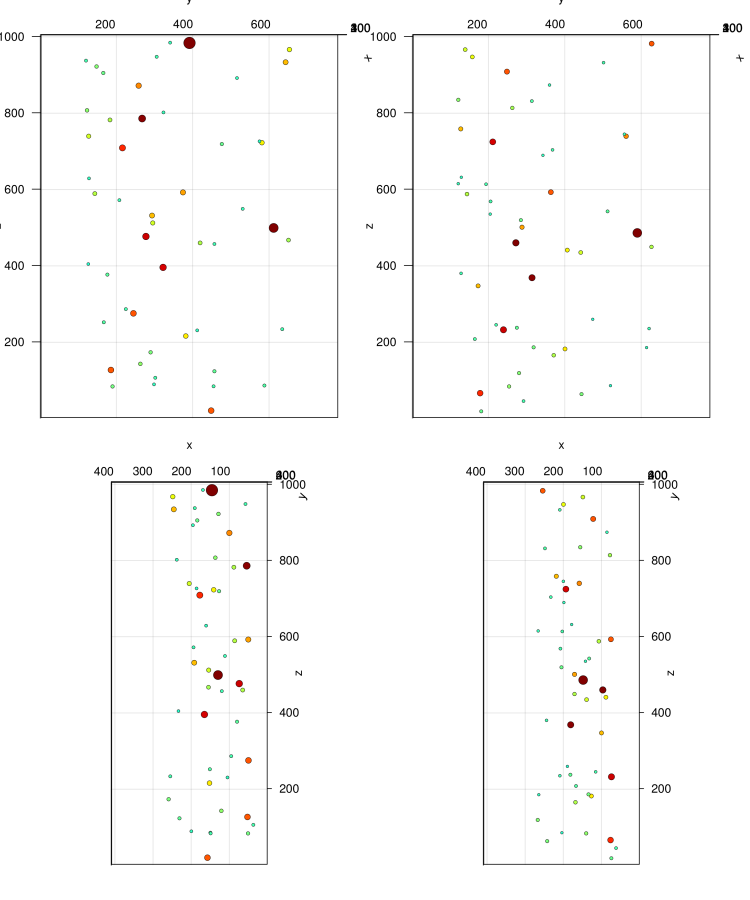

In [4]:
let
    particles0_tem, particles1_tem = CSV.read("data/particles0.csv", DataFrame), CSV.read("data/particles1.csv", DataFrame)
    candidate = particles0_tem[1:50, :]
    target = particles1_tem[1:50, :]
    colorr = (10,500)

    fig = Figure(resolution = (1000, 1200))
    ax = Axis3(fig[1, 1], aspect = :data, elevation = 0π, azimuth = 0π)
    s1 = scatter!(candidate.x, candidate.y, candidate.z, color = candidate.n, 
        colormap = :jet1, colorrange = colorr, marker = :circle, strokecolor = :black, strokewidth = 0.5, markersize = candidate.n/40)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)
    #Colorbar(fig[1, 2], s1, height = Relative(0.5), flipaxis = false, width = 12)

    ax = Axis3(fig[1, 2], aspect = :data, elevation = 0π, azimuth = 0π)
    s2 = scatter!(target.x, target.y, target.z, color = candidate.n, 
        colormap = :jet1, colorrange = colorr, marker = :circle, strokecolor = :black, strokewidth = 0.5, markersize = target.n/40)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)
    #Colorbar(fig[1, 4], s2, height = Relative(0.5), flipaxis = false, width = 12)

    ax = Axis3(fig[2, 1], aspect = :data, elevation = 0π, azimuth = 0.5π)
    s1 = scatter!(candidate.x, candidate.y, candidate.z, color = candidate.n, 
        colormap = :jet1, colorrange = colorr, marker = :circle, strokecolor = :black, strokewidth = 0.5, markersize = candidate.n/40)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)
    #Colorbar(fig[1, 2], s1, height = Relative(0.5), flipaxis = false, width = 12)

    ax = Axis3(fig[2, 2], aspect = :data, elevation = 0π, azimuth = 0.5π)
    s2 = scatter!(target.x, target.y, target.z, color = candidate.n, 
        colormap = :jet1, colorrange = colorr, marker = :circle, strokecolor = :black, strokewidth = 0.5, markersize = target.n/40)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)
    #Colorbar(fig[1, 4], s2, height = Relative(0.5), flipaxis = false, width = 12)
    
    display(fig)
    # save("test0.svg", fig)
end

In [5]:
let
# manually match the largest 10 particles
    particles0_tem, particles1_tem = CSV.read("data/particles0.csv", DataFrame), CSV.read("data/particles1.csv", DataFrame)
    matched = DataFrame(
        x0=Float32[], y0=Float32[], z0=Float32[], n0=Int32[], h0=Int32[], 
        x1=Float32[], y1=Float32[], z1=Float32[], n1=Int32[], h1=Int32[], trust=Float32[])
    mm = [2,4,5,7,6,9,10,11,16,15,18,17,31,14,20,28,40,25,19]
    nn = [1,2,3,4,5,6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19]
    for i in 1:length(mm)
        if particles1_tem.n[nn[i]]>particles0_tem.n[mm[i]]
            trust = particles1_tem.n[nn[i]]/particles0_tem.n[mm[i]]
        else
            trust = particles0_tem.n[mm[i]]/particles1_tem.n[nn[i]]
        end
        push!(matched, [Matrix(particles0_tem[[mm[i]],:])  Matrix(particles1_tem[[nn[i]],:])  trust])
    end
    deleteat!(particles0_tem, sort(mm))
    deleteat!(particles1_tem, sort(nn))
# automatically match particles
    search_r = 10
    trust_it = 20
    ε = 0.11
    for i in 1:3000
        Δd = sqrt.(sum((Matrix(particles1_tem[[1],1:3]).-Matrix(matched[:,6:8])).^2, dims=2))[:]
        iselect = sortperm(Δd)[1:10]
        tem0, tem1 = Matrix(matched[iselect,1:3]), Matrix(matched[iselect,6:8])
        tem00 = mean((Matrix(particles1_tem[[1],1:3]).-tem1)./[1-ε/2 1-ε/2 ε+1]+tem0, dims=1)
        Δdd = sqrt.(sum((Matrix(particles0_tem[:,1:3]).-tem00).^2, dims=2))[:]
        iselect = Δdd.<search_r
        Δdd = Δdd[iselect]
        if sum(iselect) == 0
            println("(", "failed at: ", round(Int, particles1_tem.x[1]), " ", round(Int, particles1_tem.y[1]), " ", round(Int, particles1_tem.z[1]),")")
            # push!(particles1_tem, particles1_tem[1,:])
            deleteat!(particles1_tem, 1)
        end
        if sum(iselect) == 1
            candidate = Matrix(particles0_tem[iselect,:])
            if particles1_tem[1,4]>candidate[1,4]
                trust = particles1_tem[1,4]/candidate[1,4]*Δdd[1]
            else
                trust = candidate[1,4]/particles1_tem[1,4]*Δdd[1]
            end
            if trust < trust_it
                # println("(", round(Int, particles1_tem.x[1]), " ", round(Int, particles1_tem.y[1]), " ", round(Int, particles1_tem.z[1]), " ", sum(iselect), " ", round(Int, trust), ")")
                pick0 = collect(1:size(particles0_tem,1))[iselect][1]
                push!(matched, [Matrix(particles0_tem[[pick0],:])  Matrix(particles1_tem[[1],:])  trust])
                deleteat!(particles0_tem, pick0)
                deleteat!(particles1_tem, 1)
            else
                # push!(particles1_tem, particles1_tem[1,:])
                deleteat!(particles1_tem, 1)
            end
        end
        if sum(iselect) > 1
            candidate = Matrix(particles0_tem[iselect,:])
            trust = zero(Δdd)
            for k in 1:sum(iselect)
                if particles1_tem[1,4]>candidate[k,4]
                    trust[k] = particles1_tem[1,4]/candidate[k,4]*Δdd[k]
                else
                    trust[k] = candidate[k,4]/particles1_tem[1,4]*Δdd[k]
                end
            end
            trust = minimum(trust)
            if trust < trust_it
                println("(", round(Int, particles1_tem.x[1]), " ", round(Int, particles1_tem.y[1]), " ", round(Int, particles1_tem.z[1]), " ", sum(iselect), " ", round(Int, trust), ")")
                pick0 = collect(1:size(particles0_tem,1))[iselect][argmin(trust)[1]]
                push!(matched, [Matrix(particles0_tem[[pick0],:])  Matrix(particles1_tem[[1],:])  trust])
                deleteat!(particles0_tem, pick0)
                deleteat!(particles1_tem, 1)
            else
                push!(particles1_tem, particles1_tem[1,:])
                deleteat!(particles1_tem, 1)
            end
        end
    end
    CSV.write("matched.csv", matched)
end

(failed at: 168 371 166)


(134 318 187 2 9)


(failed at: 74 181 19)
(209 621 236 2 5)
(183 479 139 2 6)
(115 257 426 2 1)
(90 427 463 2 7)
(252 304 238 2 4)
(208 135 664 2 1)
(171 430 450 2 1)
(203 118 241 2 3)
(failed at: 86 251 799)
(206 202 361 2 0)
(182 547 189 2 1)
(150 385 404 2 1)
(156 386 793 2 2)
(213 591 337 2 2)
(128 457 948 2 1)
(155 612 669 2 1)
(108 437 526 2 2

)
(70 560 455 2 2)
(187 640 347 2 2)
(118 636 488 2 1)
(96 199 282 2 1)
(148 602 580 2 0)
(failed at: 149 461 740)
(145 590 848 2 1)


(119 396 613 3 1)
(70 558 481 2 2)
(159 610 273 2 1)
(235 449 252 2 3)
(failed at: 205 288 535)
(220 225 510 2 1)
(200 248 972 2 2)
(166 447 547 2 1)
(205 546 648 2 0)
(196 306 254 2 1)
(154 341 470 2 1)
(213 388 490 2 7)
(160 350 210 2 6)
(242 372 277 2 1)
(123 194 115 2 0)
(74 572 133 2 2)
(160 445 579 2 1)
(167 272 931 2 1)
(failed at: 115 190 813)
(260 223 873 2 4)
(62 499 174 2 3)
(287 151 361 2 1)
(206 637 782 3 2)
(200 526 179 2 1)
(188 329 315 2 1)


(121 605 568 2 2)
(189 592 570 2 1)
(188 407 982 2 1)
(202 137 686 2 1)
(226 419 804 2 1)
(260 282 80 2 1)
(87 554 296 2 1)
(138 435 490 2 1)
(75 195 979 2 2)
(127 335 92 2 1)
(160 544 341 2 1)
(139 289 666 2 1)
(91 185 782 2 1)
(failed at: 75 266 829)
(201 527 161 2 1)
(249 599 599 2 1)
(130 153 832 2 1)
(176 252 172 2 1)
(69 559 469 2 1)
(194 116 89 2 1)
(170 453 278 2 4)
(123 426 379 2 1)
(failed at: 118 635 514)
(241 275 943 2 1)
(167 480 165 3 1)
(204 546 627 2 1)


(214 422 105 2 1)
(143 522 167 3 1)
(150 379 86 2 0)
(67 358 118 2 2)
(failed at: 81 115 933)
(279 329 941 3 1)
(151 563 225 2 1)
(221 300 291 2 1)
(147 136 551 2 1)
(224 343 566 2 1)
(207 517 646 2 0)


(225 136 517 2 1)
(86 162 683 2 1)
(168 563 463 2 0)
(159 186 87 3 1)
(116 542 407 2 1)
(259 563 456 2 0)
(167 551 518 2 1)
(126 412 681 2 2)
(293 322 707 2 2)
(142 265 942 2 2)
(109 589 226 2 1)
(107 383 423 2 1)
(261 440 656 2 0)
(83 229 863 2 2)
(285 218 888 2 1)
(218 651 982 2 11)
(failed at: 161 288 145)
(247 402 197 2 1)
(246 467 385 2 2)
(180 533 458 2 1)
(154 230 311 3 1)
(197 550 408 2 1)
(170 408 453 2 0)
(219 634 567 2 1)
(failed at: 201 621 638)
(78 392 698 2 1)
(220 550 898 2 1)
(97 487 691 2 1)
(75 354 887 2 1)


(162 375 488 2 0)
(220 224 502 2 1)
(265 152 801 2 1)
(170 276 939 2 1)
(165 167 126 3 0)
(204 135 356 3 0)
(failed at: 150 107 828)
(76 155 219 2 0)
(115 627 436 2 0)
(failed at: 215 186 740)
(266 273 970 2 1)
(130 420 164 2 6)
(253 147 254 2 1)


(68 336 336 2 1)
(103 298 481 2 1)
(failed at: 140 158 619)
(86 178 43 2 1)
(64 276 63 2 1)
(100 288 858 2 1)
(failed at: 103 390 78)
(146 139 153 2 1)
(100 472 813 3 2)
(195 382 937 2 1)
(91 118 958 2 2)
(281 253 958 2 0)
(62 498 152 2 2)
(202 620 662 2 0)
(290 126 868 2 2)
(158 232 929 2 1)
(66 614 22 2 3)
(225 626 177 2 5)


(198 353 724 2 1)
(282 596 254 2 1)
(241 414 403 2 1)
(122 270 543 2 0)
(129 274 866 2 0)
(188 518 886 2 0)
(159 303 41 2 1)
(68 367 328 2 1)
(129 298 556 2 1)
(177 385 556 2 1)
(166 190 40 2 1)
(240 325 48 2 1)
(73 197 303 2 1)
(266 182 390 2 1)
(failed at: 245 323 502)
(failed at: 238 118 698)
(197 225 765 2 1)
(155 412 863 3 1)


(187 425 487 2 0)
(failed at: 118 637 500)
(105 634 548 2 1)
(92 361 557 2 1)
(221 526 574 2 0)
(292 344 822 2 1)
(155 232 861 2 1)
(212 425 138 2 1)
(266 124 682 2 1)
(146 267 900 2 1)
(153 276 954 2 0)
(82 285 32 2 1)
(221 214 45 2 2)
(92 212 249 2 1)
(181 346 259 2 1)
(277 369 775 2 0)
(305 493 789 2 2)
(197 337 817 2 0)


(335 537 896 2 3)
(212 623 600 2 0)
(185 503 946 2 0)
(failed at: 56 521 100)
(236 249 208 2 0)
(174 262 251 2 0)
(176 131 381 2 8)
(268 188 409 2 1)
(140 195 446 2 1)
(143 467 623 2 4)
(failed at: 106 161 800)
(failed at: 184 504 956)
(173 581 118 2 1)
(148 521 130 2 1)
(130 311 267 2 0)
(235 583 468 2 0)


(154 238 892 2 0)
(failed at: 191 114 980)
(197 651 33 2 2)
(301 627 79 2 1)
(86 574 94 2 1)
(84 306 153 2 1)
(155 134 175 3 1)
(234 415 257 3 1)
(268 117 684 2 1)
(244 426 800 2 0)
(failed at: 239 317 809)
(259 429 819 2 1)
(87 618 489 2 1)


(278 283 695 2 1)
(145 432 806 2 1)
(264 281 856 2 0)
(158 523 856 2 1)
(211 288 984 2 1)
(261 162 347 2 1)
(223 423 384 2 0)
(82 126 495 2 1)
(259 308 650 2 1)
(281 136 789 2 1)
(125 475 806 2 1)
(74 214 885 3 1)
(161 577 21 2 1)
(266 392 95 2 1)
(176 149 441 2 1)
(139 274 484 2 1)
(248 150 508 2 1)
(209 508 528 2 1)
(161 153 541 2 0)
(236 200 584 2 1)
(86 589 686 2 1)


(72 171 905 2 0)
(203 568 950 2 0)
(281 484 83 2 1)
(115 428 265 2 0)
(120 637 296 2 2)
(181 129 356 2 0)
(200 500 635 2 1)
(133 603 876 2 1)
(85 642 940 2 2)
(failed at: 155 155 493)
(228 492 647 3 0)
(128 540 701 2 6)
(233 154 775 2 0)


(255 199 951 2 1)
(194 394 70 2 1)
(failed at: 243 119 173)
(234 585 346 2 0)
(failed at: 171 230 464)
(119 573 760 2 0)
(149 438 767 2 1)
(122 553 977 2 0)
(119 163 52 2 1)
(147 139 138 2 1)
(163 573 197 2 0)


(307 536 203 2 1)
(246 422 212 2 0)
(252 434 253 2 0)
(120 231 297 2 1)
(110 536 315 2 1)
(146 273 336 2 1)
(102 338 475 2 0)
(169 560 523 2 1)
(failed at: 182 518 645)
(failed at: 189 608 710)
(167 469 731 2 1)
(159 397 858 2 0)
(196 303 76 2 1)
(270 322 127 2 0)
(240 522 145 2 1)
(146 380 212 2 5)
(224 293 241 2 7)
(178 255 297 2 1)
(227 175 455 2 0)
(121 398 509 2 1)
(208 461 612 2 1)


(120 202 652 2 0)
(91 356 947 2 0)
(failed at: 57 536 123)
(156 285 161 3 1)
(failed at: 181 555 183)
(245 144 191 2 1)
(155 227 299 2 1)
(failed at: 124 117 405)
(159 143 448 2 0)
(105 169 484 2 1)
(192 608 510 2 1)
(112 251 665 2 0)
(188 390 775 2 1)


(202 576 948 2 0)
(190 398 971 2 0)
(failed at: 267 372 975)
(78 388 124 2 1)
(275 505 190 2 1)
(235 216 455 2 0)
(76 278 541 2 1)
(224 429 578 2 1)
(232 614 683 2 0)
(failed at: 127 532 700)
(146 632 728 2 0)
(216 512 923 2 1)
(159 225 936 2 1)
(failed at: 111 388 76)
(214 422 95 3 1)
(163 177 126 2 1)
(265 381 170 3 1)
(82 351 177 2 1)
(189 337 225 3 0)
(141 508 301 2 1)


(297 226 557 2 0)
(223 229 571 2 1)
(169 289 612 2 0)
(285 523 656 2 1)
(293 477 672 2 1)
(153 541 737 2 1)
(229 108 761 2 1)
(180 120 766 3 1)
(204 427 768 2 0)
(failed at: 161 162 865)
(159 226 943 2 1)
(failed at: 154 114 72)
(84 515 135 2 1)
(239 413 263 2 1)
(failed at: 74 369 584)


(249 232 692 2 1)
(164 379 733 2 0)
(failed at: 231 313 817)
(failed at: 134 162 917)
(224 130 929 2 1)
(319 638 932 2 3)
(failed at: 319 644 935)
(93 140 948 2 1)
(failed at: 57 478 117)
(64 309 283 2 0)
(65 287 295 2 1)


(failed at: 102 274 312)
(167 563 475 2 0)
(failed at: 204 636 496)
(173 400 634 2 1)
(287 584 828 2 1)
(150 376 839 2 0)
(126 559 857 3 1)
(failed at: 97 147 943)
(282 288 968 2 0)
(failed at: 56 421 150)
(failed at: 218 286 238)
(133 137 274 2 1)
(258 622 288 2 0)
(68 359 317 3 1)


(failed at: 282 136 426)
(111 593 499 2 1

)


"matched.csv"

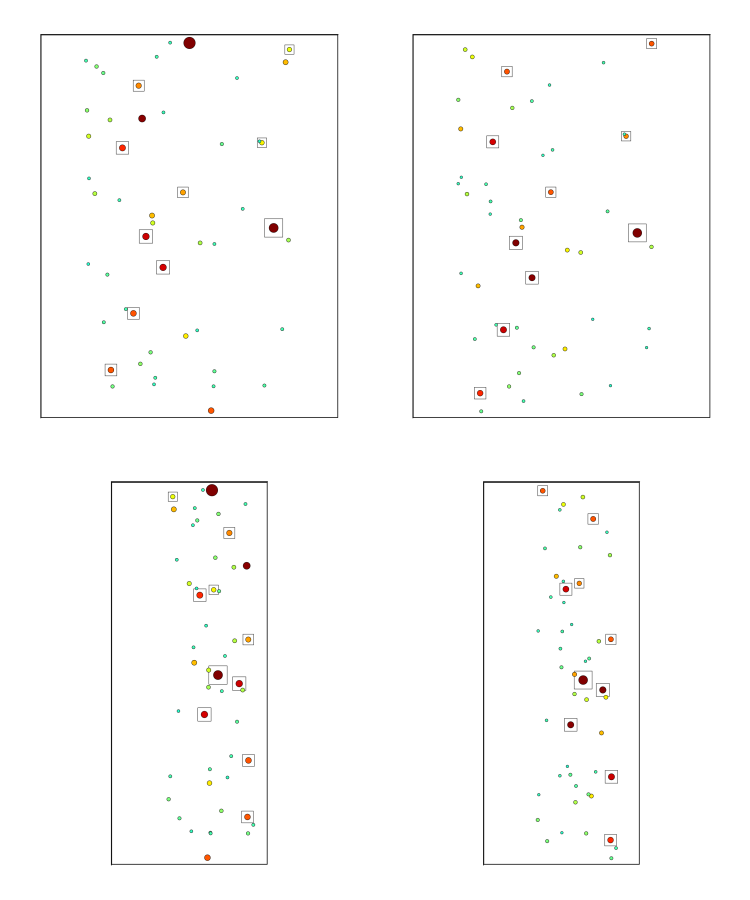

In [5]:
let
    matched = CSV.read("matched.csv", DataFrame)
    particles0_tem, particles1_tem = CSV.read("data/particles0.csv", DataFrame), CSV.read("data/particles1.csv", DataFrame)
    candidate = particles0_tem[1:50, :]
    target = particles1_tem[1:50, :]
    colorr = (10,500)

    update_theme!(font = "Palatino Linotype", fontsize = 12)
    fig = Figure(resolution = (1000, 1200))
    ax = Axis3(fig[1, 1], aspect = :data, elevation = 0π, azimuth = 0π)
    scatter!(matched.x0[1:10], matched.y0[1:10], matched.z0[1:10], color = :white, marker = :rect, strokecolor = :black, strokewidth = 0.5, markersize = matched.n0[1:10]/20)
    s1 = scatter!(candidate.x, candidate.y, candidate.z, color = candidate.n, 
        colormap = :jet1, colorrange = colorr, marker = :circle, strokecolor = :black, strokewidth = 0.5, markersize = candidate.n/40)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)
    #Colorbar(fig[1, 2], s1, height = Relative(0.5), flipaxis = false, width = 12)
    hidedecorations!(ax)  # hides ticks, grid and lables

    ax = Axis3(fig[1, 2], aspect = :data, elevation = 0π, azimuth = 0π)
    scatter!(matched.x1[1:10], matched.y1[1:10], matched.z1[1:10], color = :white, marker = :rect, strokecolor = :black, strokewidth = 0.5, markersize = matched.n1[1:10]/20)
    s2 = scatter!(target.x, target.y, target.z, color = candidate.n, 
        colormap = :jet1, colorrange = colorr, marker = :circle, strokecolor = :black, strokewidth = 0.5, markersize = target.n/40)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)
    #Colorbar(fig[1, 4], s2, height = Relative(0.5), flipaxis = false, width = 12)
    hidedecorations!(ax)  # hides ticks, grid and lables

    ax = Axis3(fig[2, 1], aspect = :data, elevation = 0π, azimuth = 0.5π)
    scatter!(matched.x0[1:10], matched.y0[1:10], matched.z0[1:10], color = :white, marker = :rect, strokecolor = :black, strokewidth = 0.5, markersize = matched.n0[1:10]/20)
    s1 = scatter!(candidate.x, candidate.y, candidate.z, color = candidate.n, 
        colormap = :jet1, colorrange = colorr, marker = :circle, strokecolor = :black, strokewidth = 0.5, markersize = candidate.n/40)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)
    #Colorbar(fig[1, 2], s1, height = Relative(0.5), flipaxis = false, width = 12)
    hidedecorations!(ax)  # hides ticks, grid and lables

    ax = Axis3(fig[2, 2], aspect = :data, elevation = 0π, azimuth = 0.5π)
    scatter!(matched.x1[1:10], matched.y1[1:10], matched.z1[1:10], color = :white, marker = :rect, strokecolor = :black, strokewidth = 0.5, markersize = matched.n1[1:10]/20)
    s2 = scatter!(target.x, target.y, target.z, color = candidate.n, 
        colormap = :jet1, colorrange = colorr, marker = :circle, strokecolor = :black, strokewidth = 0.5, markersize = target.n/40)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)
    #Colorbar(fig[1, 4], s2, height = Relative(0.5), flipaxis = false, width = 12)
    hidedecorations!(ax)  # hides ticks, grid and lables

    display(fig)
    save("test0.svg", fig)
end

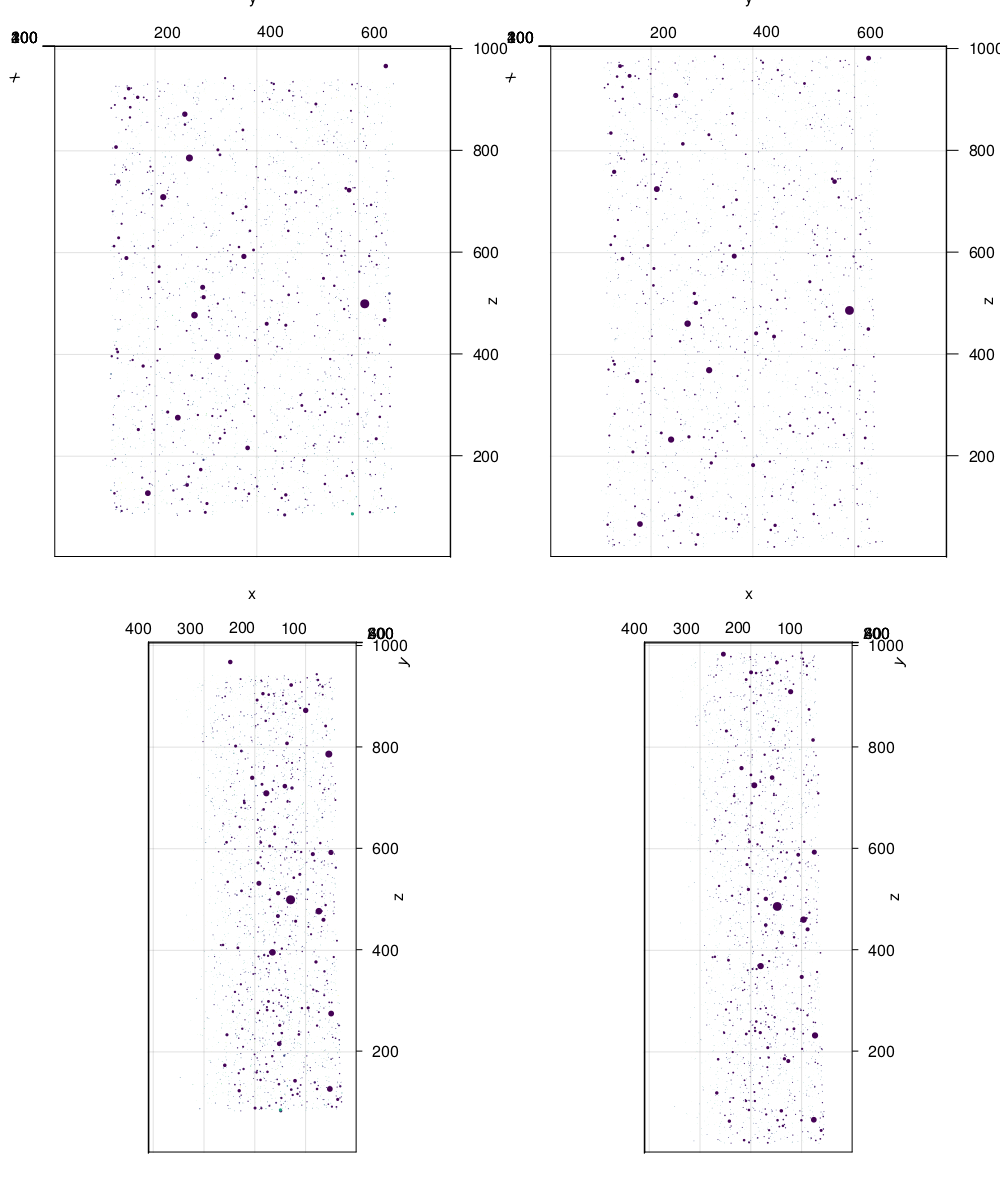

CairoMakie.Screen{SVG}


In [6]:
let
    matched = CSV.read("matched.csv", DataFrame)
    fig = Figure(resolution = (1000, 1200))
    ax = Axis3(fig[1, 1], aspect = :data, elevation = 0π, azimuth = 0)
    s1 = scatter!(matched.x0, matched.y0, matched.z0, color = 1:size(matched,1), colorrange = (1,size(matched,1)), markersize = matched.n0/50)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)

    ax = Axis3(fig[1, 2], aspect = :data, elevation = 0π, azimuth = 0)
    s2 = scatter!(matched.x1, matched.y1, matched.z1, color = 1:size(matched,1), colorrange = (1,size(matched,1)), markersize = matched.n1/50)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)

    ax = Axis3(fig[2, 1], aspect = :data, elevation = 0π, azimuth = 0.5π)
    s1 = scatter!(matched.x0, matched.y0, matched.z0, color = 1:size(matched,1), colorrange = (1,size(matched,1)), markersize = matched.n0/50)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)

    ax = Axis3(fig[2, 2], aspect = :data, elevation = 0π, azimuth = 0.5π)
    s2 = scatter!(matched.x1, matched.y1, matched.z1, color = 1:size(matched,1), colorrange = (1,size(matched,1)), markersize = matched.n1/50)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)

    # Colorbar(fig[1:2, 3], s2, height = Relative(0.5), flipaxis = false, width = 12)

    display(fig)
    save("test.svg", fig)
end

In [7]:
let
    include("../../../function_julia/function_LRG.jl")
    matched = CSV.read("matched.csv", DataFrame)
    xyz_particle_0, xyz_particle_1 = Matrix{Float32}(matched[:,1:3]), Matrix{Float32}(matched[:,6:8])
    x, y, z = Float64.(matched[:,1]), Float64.(matched[:,2]), Float64.(matched[:,3])
    mat"""
        DT = delaunayTriangulation([$x $y $z])
        [C, r_outer] = circumcenter(DT);
        [C, r_inter] = incenter(DT);
        %tetramesh(DT, 'FaceAlpha', 0.7);
        $tetra = DT.ConnectivityList;
        $radi_outer = r_outer;
        $radi_inter = r_inter;
    """
    tetra = Int32.(tetra)
    radi_outer, radi_inter = Float32.(radi_outer), Float32.(radi_inter)
    n_tetrahedron = length(tetra[:,1])
    volume_tetrahedron = zeros(Float32, n_tetrahedron)
    xyz_tetrahedron = zeros(Float32, n_tetrahedron, 3)
    for i in 1:n_tetrahedron
        xyz_tetrahedron[i,:] = sum(xyz_particle_0[tetra[i,:],:], dims=1)./4
        volume_tetrahedron[i] = Tetrahedron_volume(
            xyz_particle_0[tetra[i,1],:], 
            xyz_particle_0[tetra[i,2],:], 
            xyz_particle_0[tetra[i,3],:], 
            xyz_particle_0[tetra[i,4],:])
    end
    strain = Calculate_strain2(tetra, xyz_particle_0, xyz_particle_1)
    df = DataFrame(
        tetra1 = tetra[:,1], tetra2 = tetra[:,2], tetra3 = tetra[:,3], tetra4 = tetra[:,4],
        x = xyz_tetrahedron[:,1], y = xyz_tetrahedron[:,2], z = xyz_tetrahedron[:,3], 
        strain_11 = strain[:,1],
        strain_22 = strain[:,2],
        strain_33 = strain[:,3],
        strain_12 = strain[:,4],
        strain_23 = strain[:,5],
        strain_13 = strain[:,6],
        strain_r1 = strain[:,7],
        strain_r2 = strain[:,8],
        strain_r3 = strain[:,9],
        volume = volume_tetrahedron,
        radius_outer = radi_outer, 
        radius_inter = radi_inter)
    CSV.write("tetra_strain_volume_2radius.csv", df)
end


DT = 

  delaunayTriangulation with properties:

              Points: [2969x3 double]
    ConnectivityList: [19336x4 double]
         Constraints: []



Calculating strain, e_xx, e_yy, e_zz, r_xy, r_yz, r_zx ...


finished

"tetra_strain_volume_2radius.csv"

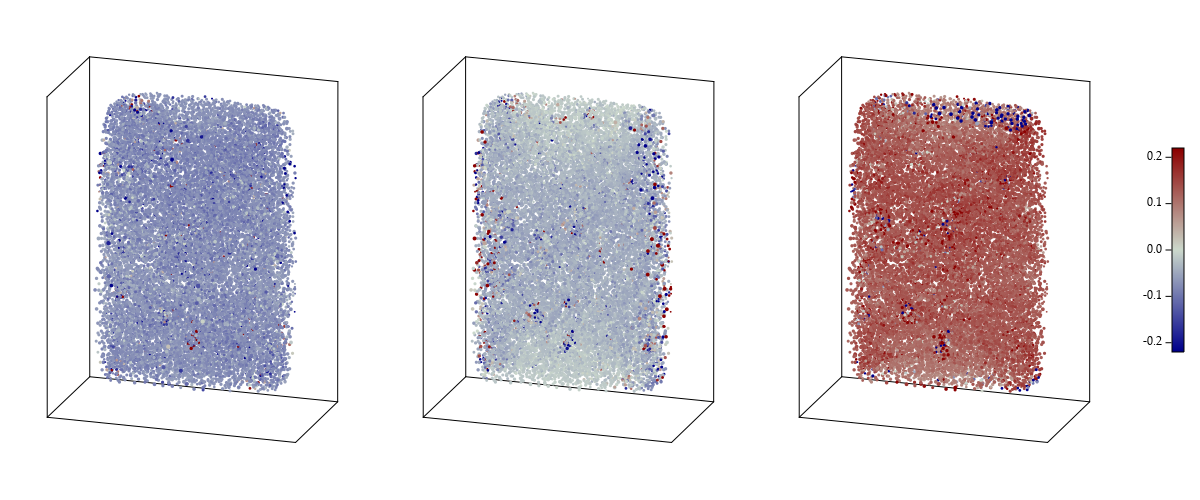

In [5]:

let   
    df = CSV.read("tetra_strain_volume_2radius.csv", DataFrame)
    update_theme!(font = "Palatino Linotype", fontsize = 12)
    fig = Figure(resolution = (1200, 500))
    ax = Axis3(fig[1, 1], aspect = :data, elevation = 0.1π, azimuth = 0.1π)
    s1 = scatter!(df.x, df.y, df.z, color = df.strain_11, colormap = :bluesreds, transparency = true, colorrange = (-0.22,0.22), markersize = @. log(df.volume)/2)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)
    hidedecorations!(ax)  # hides ticks, grid and lables

    ax = Axis3(fig[1, 2], aspect = :data, elevation = 0.1π, azimuth = 0.1π)
    s1 = scatter!(df.x, df.y, df.z, color = df.strain_22, colormap = :bluesreds, transparency = true, colorrange = (-0.22,0.22), markersize = @. log(df.volume)/2)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)
    hidedecorations!(ax)  # hides ticks, grid and lables

    ax = Axis3(fig[1, 3], aspect = :data, elevation = 0.1π, azimuth = 0.1π)
    s1 = scatter!(df.x, df.y, df.z, color = df.strain_33, colormap = :bluesreds, transparency = true, colorrange = (-0.22,0.22), markersize = @. log(df.volume)/2)
    limits!(ax::Axis3, 1, lx, 1, ly, 1, lz)
    hidedecorations!(ax)  # hides ticks, grid and lables

    Colorbar(fig[1, 4], s1, height = Relative(0.5), flipaxis = false, width = 12)
    
    display(fig)
    # save("strain.svg", fig)
end

In [9]:
let     
    include("../../../function_julia/function_LRG.jl")
    x_slice = 200
    (x, y, z) = ndgrid_array(1:lx, 1:ly, 1:lz)
    x, y, z = x[:], y[:], z[:]
    strain = zeros(Float32, size(x,1), 6)
    iselect = x.==x_slice
    x, y, z, strain = x[iselect], y[iselect], z[iselect], strain[iselect,:]
    id = collect(1:size(x,1))
    xyz_particle_0 = Matrix{Float32}(CSV.read("matched.csv", DataFrame)[:,1:3])
    df = CSV.read("tetra_strain_volume_2radius.csv", DataFrame)
    for i in 1:size(df,1)
        vertex_xyzs = xyz_particle_0[[df.tetra1[i],df.tetra2[i],df.tetra3[i],df.tetra4[i]], :]
        if x_slice.>minimum(vertex_xyzs[:,1]) .&& x_slice.<maximum(vertex_xyzs[:,1])
            # print(i, " ")
            iselect1 = x.>minimum(vertex_xyzs[:,1]) .&& x.<maximum(vertex_xyzs[:,1])
            iselect2 = y.>minimum(vertex_xyzs[:,2]) .&& y.<maximum(vertex_xyzs[:,2]) 
            iselect3 = z.>minimum(vertex_xyzs[:,3]) .&& z.<maximum(vertex_xyzs[:,3])
            iselect = iselect1 .&& iselect2 .&& iselect3
            p_xyzs = Float32.([x[iselect] y[iselect] z[iselect]])
            t_inflag = point_in_tetra_or_not(p_xyzs, vertex_xyzs)
            
            strain[id[iselect][t_inflag.==1], :] .= Vector{Float32}(df[i,8:13])'
        end
    end
    save("strain.jld", "strain", strain)
end

Excessive output truncated after 10485760 bytes.

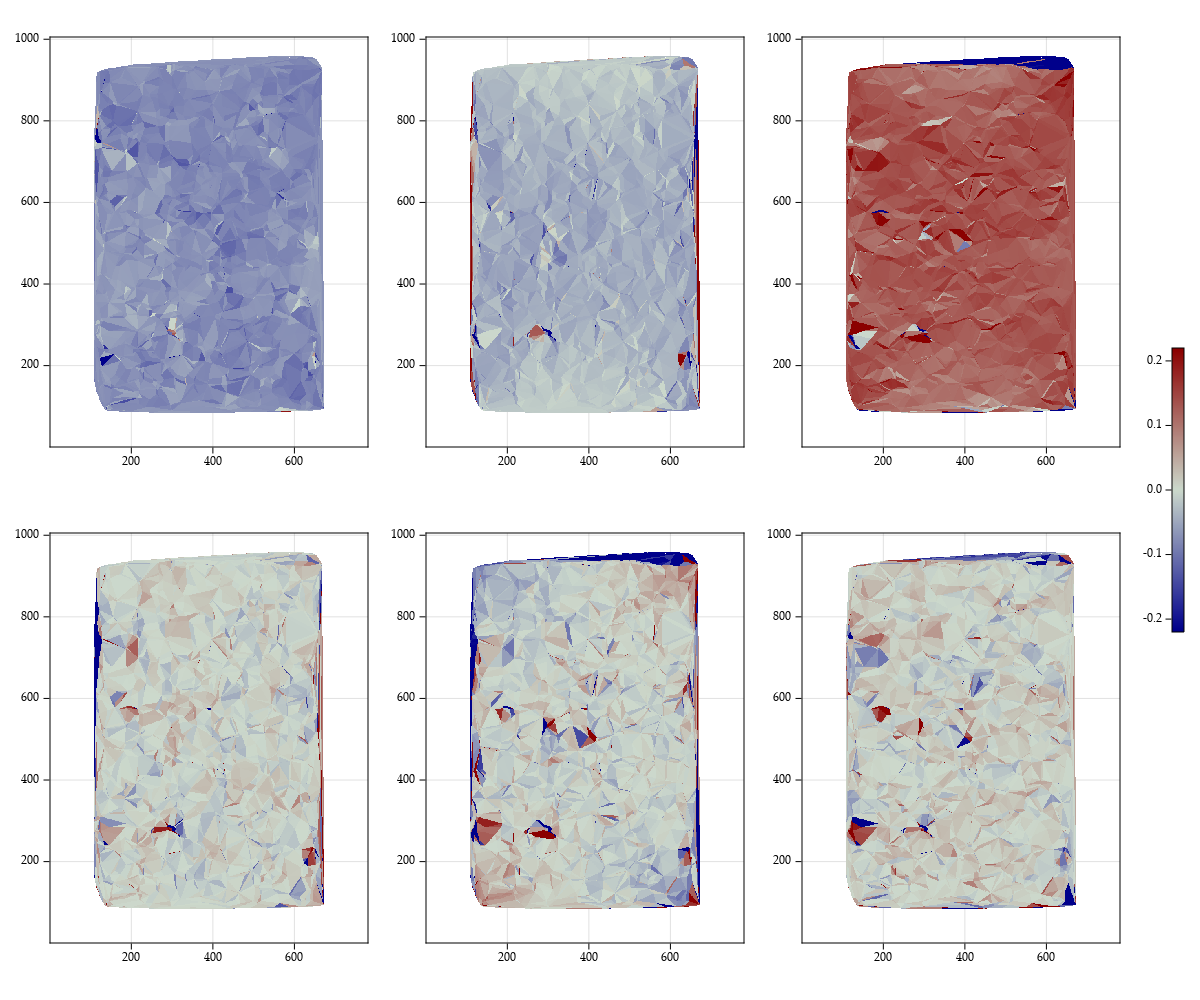

CairoMakie.Screen{IMAGE}


In [4]:
let     
    include("../../../function_julia/function_LRG.jl")
    strain_all = load("strain.jld")["strain"]
    strain_all[strain_all[:,1].==0, :] .= NaN
    (y, z) = ndgrid_array(1:ly, 1:lz)
    y, z = y[:], z[:]
    strain11, strain22, strain33, strain12, strain23, strain13 = zeros(ly, lz), zeros(ly, lz), zeros(ly, lz), zeros(ly, lz), zeros(ly, lz), zeros(ly, lz)
    @floop for i in 1:size(y,1)
        strain11[y[i], z[i]] = strain_all[i,1]
        strain22[y[i], z[i]] = strain_all[i,2]
        strain33[y[i], z[i]] = strain_all[i,3]
        strain12[y[i], z[i]] = strain_all[i,4]
        strain23[y[i], z[i]] = strain_all[i,5]
        strain13[y[i], z[i]] = strain_all[i,6]
    end

    update_theme!(font = "Palatino Linotype", fontsize = 12)
    fig = Figure(resolution = (1200, 1000))
    
    ax = Axis(fig[1, 1], aspect = DataAspect())
    hm = heatmap!(strain11, colormap = :bluesreds, colorrange = (-0.22, 0.22))
    ax = Axis(fig[1, 2], aspect = DataAspect())
    hm = heatmap!(strain22, colormap = :bluesreds, colorrange = (-0.22, 0.22))
    ax = Axis(fig[1, 3], aspect = DataAspect())
    hm = heatmap!(strain33, colormap = :bluesreds, colorrange = (-0.22, 0.22))

    ax = Axis(fig[2, 1], aspect = DataAspect())
    hm = heatmap!(strain12, colormap = :bluesreds, colorrange = (-0.22, 0.22))
    ax = Axis(fig[2, 2], aspect = DataAspect())
    hm = heatmap!(strain23, colormap = :bluesreds, colorrange = (-0.22, 0.22))
    ax = Axis(fig[2, 3], aspect = DataAspect())
    hm = heatmap!(strain13, colormap = :bluesreds, colorrange = (-0.22, 0.22))
    Colorbar(fig[1:2, 4], hm, height = Relative(0.3), flipaxis = false, width = 12)
    display(fig)

    save("strain_2d.png", fig)
    #
end

In [ ]:
begin
    # match the largest 100 particles
    candidate = particles1[sortperm(particles1.n, rev=true)[1:500], :]
    target = particles2[sortperm(particles2.n, rev=true)[1:50], :]
    Δd = 100
    ε = 0.11
    search_grain = 10
    Δdxy, Δdz = Δd*(1-ε/2), Δd*(1+ε)
    data1 = zeros(search_grain, 4, size(target,1))
    @floop for i in 1:size(target,1)
        iselect = (@. abs(particles1.x-target.x[i])<Δdxy) .&& (@. abs(particles1.y-target.y[i])<Δdxy) .&& (@. abs(particles1.z-target.z[i])<Δdz)
        tem = particles1[iselect,:]
        tem = tem[sortperm(tem.n, rev=true)[1:search_grain], :]
        data1[:,:,i] = [tem[:,1].-target[i,1]  tem[:,2].-target[i,2]  tem[:,3].-target[i,3]  tem[:,4]./target[i,4]]
    end
    data2 = zeros(search_grain, 4, size(candidate,1))
    @floop for i in 1:size(candidate,1)
        iselect = (@. abs(particles2.x-candidate.x[i])<Δd) .&& (@. abs(particles2.y-candidate.y[i])<Δd) .&& (@. abs(particles2.z-candidate.z[i])<Δd)
        tem = particles2[iselect,:]
        tem = tem[sortperm(tem.n, rev=true)[1:search_grain], :]
        data2[:,:,i] = [tem[:,1].-candidate[i,1]  tem[:,2].-candidate[i,2]  tem[:,3].-candidate[i,3]  tem[:,4]./candidate[i,4]]
    end
end
begin
    match = DataFrame(
        x0=zero(target.x), y0=zero(target.x), z0=zero(target.x), n0=Int32.(zero(target.x)), h0=Int32.(zero(target.x)), 
        x1=zero(target.x), y1=zero(target.x), z1=zero(target.x), n1=Int32.(zero(target.x)), h1=Int32.(zero(target.x)), trust=zero(target.x))
    tem1 = zeros(size(candidate,1))
    tem = zeros(search_grain,search_grain)
    @floop for i in 1:size(target,1)
        for j in 1:size(candidate,1)
            for k in 1:search_grain, m in 1:search_grain
                tem[k,m] = sum(abs.(data1[k,1:3,i] - data2[m,1:3,j]))*abs(1-data1[k,4,i]/data2[m,4,j])
            end
            tem1[j] = sum(sort(tem[:])[2:1+Int32(search_grain/2)])
        end
        am = argmin(tem1)
        match[i,:] = [candidate.x[am] candidate.y[am] candidate.z[am] candidate.n[am] candidate.h[am] target.x[i] target.y[i] target.z[i] target.n[i] target.h[i] tem1[am]]
    end
end
match

In [ ]:
act = copy(act1)
particles = DataFrame(x=Int32[], y=Int32[], z=Int32[], dx1=Int32[], dx2=Int32[], dy1=Int32[], dy2=Int32[], dz1=Int32[], dz2=Int32[], h=Float32[])
for i in 21:length(act[:,1,1])-20, j in 21:length(act[1,:,1])-20, k in 21:length(act[1,1,:])-20
    if act[i,j,k]>0
        if act[i,j,k]>maximum(act[i-1:i+1, j-1:j+1, k-1:k+1][:][vcat(1:13, 15:27)])
            dx1, dx2 = i + findfirst(isequal(0), act[i+1:i+20, j, k]), i - findfirst(isequal(0), act[i-1:-1:i-20, j, k])
            dy1, dy2 = j + findfirst(isequal(0), act[i, j+1:j+20, z]), j - findfirst(isequal(0), act[i, j-1:-1:j-20, k])
            dz1, dz2 = k + findfirst(isequal(0), act[i, j, k+1:k+20]), k - findfirst(isequal(0), act[i, j, k-1:-1:k-20])
            println(dx1, dx2, dy1, dy2, dz1, dz2)
            #push!(particles, [i, j, k, dx1, dx2, dy1, dy2, dz1, dz2, sum(act[dx1:dx2, dy1:dy2, dz1:dz2])])
        end
    end
end
particles1 = copy(particles);

In [ ]:
z = 401
B1, B2 = act1[:,:,z], act2[:,:,z]
# px1, py1, px2, py2 = 1:length(B1[:,1]), 1:length(B1[1,:]), 1:length(B2[:,1]), 1:length(B2[1,:])
px1, py1, px2, py2 = 51:100, 51:150, 51:100, 51:150

update_theme!(font = "Palatino Linotype", fontsize = 12)
fig = Figure(resolution = (1200, 350))

ax = Axis(fig[1, 1], aspect = DataAspect())
hm = heatmap!(B1[px1,py1]', colormap = :jet1, colorrange = (minimum(B1[:][B1[:].>0]), maximum(B1[:][B1[:].>0])))
#

ax = Axis(fig[1, 2], aspect = DataAspect())
hm = heatmap!(B2[px2,py2]', colormap = :jet1, colorrange = (minimum(B2[:][B2[:].>0]), maximum(B2[:][B2[:].>0])))
Colorbar(fig[1, 3], hm, height = Relative(0.5), flipaxis = false, width = 12)
#
display(fig)

In [ ]:
# test
#x = [370, 705]
#y = [210, 780]
z = 1
A = -act_1[:,:,z]
A = A.-minimum(A)
lx, ly = length(A[:,1]), length(A[1,:])
A1 = copy(A)
for i in 6:lx-5, j in 6:ly-5
    ave = mean(A[i-5:i+5,j-5:j+5])
    for ii in 1:11, jj in 1:11
        if A[ii,jj]<1.2ave
            A[ii,jj]=0
        end
    end
end

A_ave_inter = mean(A[100:end-100, 100:end-100])
A_ave_outer = mean(A[1:end, 1])-0
println(A_ave_inter)
println(A_ave_outer)

for i in 1:length(A[:,1]), j in 1:length(A[1,:])
    if A[i,j]<A_ave_inter+0.05 #&& A[i,j]<A_ave_outer
        A1[i,j] = 0
    end
end

# px, py = 1:length(A[:,1]), 1:length(A[1,:])
px, py = 51:150, 51:250

update_theme!(font = "Palatino Linotype", fontsize = 12)
fig = Figure(resolution = (1200, 350))

ax = Axis(fig[1, 1], aspect = DataAspect())
hm = heatmap!(A[px,py]', colormap = :jet1, colorrange = (A_ave_inter, A_ave_outer))
#

ax = Axis(fig[1, 2], aspect = DataAspect())
hm = heatmap!(A1[px,py]', colormap = :jet1, colorrange = (A_ave_inter, A_ave_outer))
Colorbar(fig[1, 3], hm, height = Relative(0.5), flipaxis = false, width = 12)

#
display(fig)

In [ ]:
# save act_polish
#x = [370, 705]
#y = [210, 780]
if ~isfile(dir*"/act_polish.jld")
    act_1_polish = act_1
    for i in 1:1005
        print(i, " ")
        A = -act_1[:,:,z]
        A = A.-minimum(A)
        A_ave_inter = mean(A[100:end-100, 100:end-100])+1000
        A_ave_outer = mean(A[1:end, 1])-1000

        for i in 1:length(A[:,1]), j in 1:length(A[1,:])
            if A[i,j]>A_ave_inter && A[i,j]<A_ave_outer
            else
                A[i,j] = 0
            end
        end
        act_1_polish[:,:,i] = A
    end
    save(dir*"/act_polish.jld", "act", act_1_polish)
end

In [ ]:
# test
let
    #x = [370, 705]
    #y = [210, 780]
    z = 1
    A = -act_1[:,:,z]
    A = A.-minimum(A)
    lx, ly = length(A[:,1]), length(A[1,:])
    A1 = copy(A)
    for i in 6:lx-5, j in 6:ly-5
        tem = A[i-5:i+5,j-5:j+5][:]
        ave = mean(tem[tem.<median(tem)])
        for ii in i-5:i+5, jj in j-5:j+5
            if A[ii,jj]<1.1ave
                A1[ii,jj]=0
            end
        end
    end
    A_ave_inter = mean(A[100:end-100, 100:end-100])
    A_ave_outer = mean(A[1:end, 1])
    println(A_ave_inter)
    println(A_ave_outer)

    px, py = 1:length(A[:,1]), 1:length(A[1,:])
    # px, py = 51:150, 51:250

    update_theme!(font = "Palatino Linotype", fontsize = 12)
    fig = Figure(resolution = (1200, 350))

    ax = Axis(fig[1, 1], aspect = DataAspect())
    hm = heatmap!(A[px,py]', colormap = :jet1, colorrange = (A_ave_inter, A_ave_outer))
    #

    ax = Axis(fig[1, 2], aspect = DataAspect())
    hm = heatmap!(A1[px,py]', colormap = :jet1, colorrange = (A_ave_inter, A_ave_outer))
    Colorbar(fig[1, 3], hm, height = Relative(0.5), flipaxis = false, width = 12)

    #
    display(fig)
end